## Multi-modal RAG



## Data Loading

### Partition PDF tables, text, and images
  
Let's look at a [popular blog](https://cloudedjudgement.substack.com/p/clouded-judgement-111023) by Jamin Ball.

This is a great use-case because much of the information is captured in images (of tables or charts).

We use `Unstructured` to partition it (see [blog post](https://blog.langchain.dev/semi-structured-multi-modal-rag/)).

---

To skip `Unstructured` extraction:

[Here](https://drive.google.com/file/d/1QlhGFIFwEkNEjQGOvV_hQe4bnOLDJwCR/view?usp=sharing) is a zip file with a sub-set of the extracted images and pdf.

If you want to use the provided folder, then simply opt for a [pdf loader](https://python.langchain.com/docs/modules/data_connection/document_loaders/pdf) for the document:

```
from langchain_community.document_loaders import PyPDFLoader
loader = PyPDFLoader(path + fname)
docs = loader.load()
tables = [] # Ignore w/ basic pdf loader
texts = [d.page_content for d in docs]
```

In [3]:
from langchain.text_splitter import CharacterTextSplitter
from unstructured.partition.pdf import partition_pdf


# Extract elements from PDF
def extract_pdf_elements(path, fname):
    """
    Extract images, tables, and chunk text from a PDF file.
    path: File path, which is used to dump images (.jpg)
    fname: File name
    """
    return partition_pdf(
        filename=path + fname,
        extract_images_in_pdf=False,
        infer_table_structure=True,
        chunking_strategy="by_title",
        max_characters=4000,
        new_after_n_chars=3800,
        combine_text_under_n_chars=2000,
        image_output_dir_path=path,
    )


# Categorize elements by type
def categorize_elements(raw_pdf_elements):
    """
    Categorize extracted elements from a PDF into tables and texts.
    raw_pdf_elements: List of unstructured.documents.elements
    """
    tables = []
    texts = []
    for element in raw_pdf_elements:
        if "unstructured.documents.elements.Table" in str(type(element)):
            tables.append(str(element))
        elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
            texts.append(str(element))
    return texts, tables


# File path
fpath = "./MM_pdf/"
fname = "mm_pdf.pdf"

# Get elements
raw_pdf_elements = extract_pdf_elements(fpath, fname)

# Get text, tables
texts, tables = categorize_elements(raw_pdf_elements)

# Optional: Enforce a specific token size for texts
text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=4000, chunk_overlap=0
)
joined_texts = " ".join(texts)
texts_4k_token = text_splitter.split_text(joined_texts)

ModuleNotFoundError: No module named 'unstructured_inference'

## Multi-vector retriever

Use [multi-vector-retriever](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector#summary) to index image (and / or text, table) summaries, but retrieve raw images (along with raw texts or tables).

### Text and Table summaries

We will use GPT-4 to produce table and, optionall, text summaries.

Text summaries are advised if using large chunk sizes (e.g., as set above, we use 4k token chunks).

Summaries are used to retrieve raw tables and / or raw chunks of text.

In [ ]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI


# Generate summaries of text elements
def generate_text_summaries(texts, tables, summarize_texts=False):
    """
    Summarize text elements
    texts: List of str
    tables: List of str
    summarize_texts: Bool to summarize texts
    """

    # Prompt
    prompt_text = """You are an assistant tasked with summarizing tables and text for retrieval. \
    These summaries will be embedded and used to retrieve the raw text or table elements. \
    Give a concise summary of the table or text that is well optimized for retrieval. Table or text: {element} """
    prompt = ChatPromptTemplate.from_template(prompt_text)

    # Text summary chain
    model = ChatOpenAI(temperature=0, model="gpt-4")
    summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

    # Initialize empty summaries
    text_summaries = []
    table_summaries = []

    # Apply to text if texts are provided and summarization is requested
    if texts and summarize_texts:
        text_summaries = summarize_chain.batch(texts, {"max_concurrency": 5})
    elif texts:
        text_summaries = texts

    # Apply to tables if tables are provided
    if tables:
        table_summaries = summarize_chain.batch(tables, {"max_concurrency": 5})

    return text_summaries, table_summaries


# Get text, table summaries
text_summaries, table_summaries = generate_text_summaries(
    texts_4k_token, tables, summarize_texts=True
)

### Image summaries 

We will use [GPT-4V](https://openai.com/research/gpt-4v-system-card) to produce the image summaries.

The API docs [here](https://platform.openai.com/docs/guides/vision):

* We pass base64 encoded images

In [ ]:
import base64
import os

from langchain_core.messages import HumanMessage


def encode_image(image_path):
    """Getting the base64 string"""
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")


def image_summarize(img_base64, prompt):
    """Make image summary"""
    chat = ChatOpenAI(model="gpt-4-vision-preview", max_tokens=1024)

    msg = chat.invoke(
        [
            HumanMessage(
                content=[
                    {"type": "text", "text": prompt},
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/jpeg;base64,{img_base64}"},
                    },
                ]
            )
        ]
    )
    return msg.content


def generate_img_summaries(path):
    """
    Generate summaries and base64 encoded strings for images
    path: Path to list of .jpg files extracted by Unstructured
    """

    # Store base64 encoded images
    img_base64_list = []

    # Store image summaries
    image_summaries = []

    # Prompt
    prompt = """You are an assistant tasked with summarizing images for retrieval. \
    These summaries will be embedded and used to retrieve the raw image. \
    Give a concise summary of the image that is well optimized for retrieval."""

    # Apply to images
    for img_file in sorted(os.listdir(path)):
        if img_file.endswith(".jpg"):
            img_path = os.path.join(path, img_file)
            base64_image = encode_image(img_path)
            img_base64_list.append(base64_image)
            image_summaries.append(image_summarize(base64_image, prompt))

    return img_base64_list, image_summaries


# Image summaries
img_base64_list, image_summaries = generate_img_summaries(fpath)

### Add to vectorstore

Add raw docs and doc summaries to [Multi Vector Retriever](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector#summary): 

* Store the raw texts, tables, and images in the `docstore`.
* Store the texts, table summaries, and image summaries in the `vectorstore` for efficient semantic retrieval.

In [ ]:
import uuid

from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage import InMemoryStore
from langchain_community.vectorstores import Chroma
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings


def create_multi_vector_retriever(
    vectorstore, text_summaries, texts, table_summaries, tables, image_summaries, images
):
    """
    Create retriever that indexes summaries, but returns raw images or texts
    """

    # Initialize the storage layer
    store = InMemoryStore()
    id_key = "doc_id"

    # Create the multi-vector retriever
    retriever = MultiVectorRetriever(
        vectorstore=vectorstore,
        docstore=store,
        id_key=id_key,
    )

    # Helper function to add documents to the vectorstore and docstore
    def add_documents(retriever, doc_summaries, doc_contents):
        doc_ids = [str(uuid.uuid4()) for _ in doc_contents]
        summary_docs = [
            Document(page_content=s, metadata={id_key: doc_ids[i]})
            for i, s in enumerate(doc_summaries)
        ]
        retriever.vectorstore.add_documents(summary_docs)
        retriever.docstore.mset(list(zip(doc_ids, doc_contents)))

    # Add texts, tables, and images
    # Check that text_summaries is not empty before adding
    if text_summaries:
        add_documents(retriever, text_summaries, texts)
    # Check that table_summaries is not empty before adding
    if table_summaries:
        add_documents(retriever, table_summaries, tables)
    # Check that image_summaries is not empty before adding
    if image_summaries:
        add_documents(retriever, image_summaries, images)

    return retriever


# The vectorstore to use to index the summaries
vectorstore = Chroma(
    collection_name="mm_rag_cj_blog", embedding_function=OpenAIEmbeddings()
)

# Create retriever
retriever_multi_vector_img = create_multi_vector_retriever(
    vectorstore,
    text_summaries,
    texts,
    table_summaries,
    tables,
    image_summaries,
    img_base64_list,
)

## RAG

### Build retriever

We need to bin the retrieved doc(s) into the correct parts of the GPT-4V prompt template.

In [ ]:
import io
import re

from IPython.display import HTML, display
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from PIL import Image


def plt_img_base64(img_base64):
    """Disply base64 encoded string as image"""
    # Create an HTML img tag with the base64 string as the source
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'
    # Display the image by rendering the HTML
    display(HTML(image_html))


def looks_like_base64(sb):
    """Check if the string looks like base64"""
    return re.match("^[A-Za-z0-9+/]+[=]{0,2}$", sb) is not None


def is_image_data(b64data):
    """
    Check if the base64 data is an image by looking at the start of the data
    """
    image_signatures = {
        b"\xFF\xD8\xFF": "jpg",
        b"\x89\x50\x4E\x47\x0D\x0A\x1A\x0A": "png",
        b"\x47\x49\x46\x38": "gif",
        b"\x52\x49\x46\x46": "webp",
    }
    try:
        header = base64.b64decode(b64data)[:8]  # Decode and get the first 8 bytes
        for sig, format in image_signatures.items():
            if header.startswith(sig):
                return True
        return False
    except Exception:
        return False


def resize_base64_image(base64_string, size=(128, 128)):
    """
    Resize an image encoded as a Base64 string
    """
    # Decode the Base64 string
    img_data = base64.b64decode(base64_string)
    img = Image.open(io.BytesIO(img_data))

    # Resize the image
    resized_img = img.resize(size, Image.LANCZOS)

    # Save the resized image to a bytes buffer
    buffered = io.BytesIO()
    resized_img.save(buffered, format=img.format)

    # Encode the resized image to Base64
    return base64.b64encode(buffered.getvalue()).decode("utf-8")


def split_image_text_types(docs):
    """
    Split base64-encoded images and texts
    """
    b64_images = []
    texts = []
    for doc in docs:
        # Check if the document is of type Document and extract page_content if so
        if isinstance(doc, Document):
            doc = doc.page_content
        if looks_like_base64(doc) and is_image_data(doc):
            doc = resize_base64_image(doc, size=(1300, 600))
            b64_images.append(doc)
        else:
            texts.append(doc)
    return {"images": b64_images, "texts": texts}


def img_prompt_func(data_dict):
    """
    Join the context into a single string
    """
    formatted_texts = "\n".join(data_dict["context"]["texts"])
    messages = []

    # Adding image(s) to the messages if present
    if data_dict["context"]["images"]:
        for image in data_dict["context"]["images"]:
            image_message = {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{image}"},
            }
            messages.append(image_message)

    # Adding the text for analysis
    text_message = {
        "type": "text",
        "text": (
            "You are financial analyst tasking with providing investment advice.\n"
            "You will be given a mixed of text, tables, and image(s) usually of charts or graphs.\n"
            "Use this information to provide investment advice related to the user question. \n"
            f"User-provided question: {data_dict['question']}\n\n"
            "Text and / or tables:\n"
            f"{formatted_texts}"
        ),
    }
    messages.append(text_message)
    return [HumanMessage(content=messages)]


def multi_modal_rag_chain(retriever):
    """
    Multi-modal RAG chain
    """

    # Multi-modal LLM
    model = ChatOpenAI(temperature=0, model="gpt-4-vision-preview", max_tokens=1024)

    # RAG pipeline
    chain = (
        {
            "context": retriever | RunnableLambda(split_image_text_types),
            "question": RunnablePassthrough(),
        }
        | RunnableLambda(img_prompt_func)
        | model
        | StrOutputParser()
    )

    return chain


# Create RAG chain
chain_multimodal_rag = multi_modal_rag_chain(retriever_multi_vector_img)

### Check

Examine retrieval; we get back images that are relevant to our question.

In [ ]:
# Check retrieval
query = "Give me company names that are interesting investments based on EV / NTM and NTM rev growth. Consider EV / NTM multiples vs historical?"
docs = retriever_multi_vector_img.get_relevant_documents(query, limit=6)

# We get 4 docs
len(docs)

In [ ]:
# Check retrieval
query = "What are the EV / NTM and NTM rev growth for MongoDB, Cloudflare, and Datadog?"
docs = retriever_multi_vector_img.get_relevant_documents(query, limit=6)

# We get 4 docs
len(docs)

In [ ]:
# We get back relevant images
plt_img_base64(docs[0])

### Sanity Check

Why does this work? Let's look back at the image that we stored ...

In [ ]:
plt_img_base64(img_base64_list[3])

... here is the corresponding summary, which we embedded and used in similarity search.

It's pretty reasonable that this image is indeed retrieved from our `query` based on it's similarity to this summary.

In [ ]:
image_summaries[3]

### RAG

Now let's run RAG and test the ability to synthesize an answer to our question.

In [ ]:
# Run RAG chain
chain_multimodal_rag.invoke(query)

Here is the trace where we can see what is passed to the LLM:
 
* Question 1 [Trace focused on investment advice](https://smith.langchain.com/public/d77b7b52-4128-4772-82a7-c56eb97e8b97/r)
* Question 2 [Trace focused on table extraction](https://smith.langchain.com/public/4624f086-1bd7-4284-9ca9-52fd7e7a4568/r)

For question 1, we can see that we pass 3 images along with a text chunk:

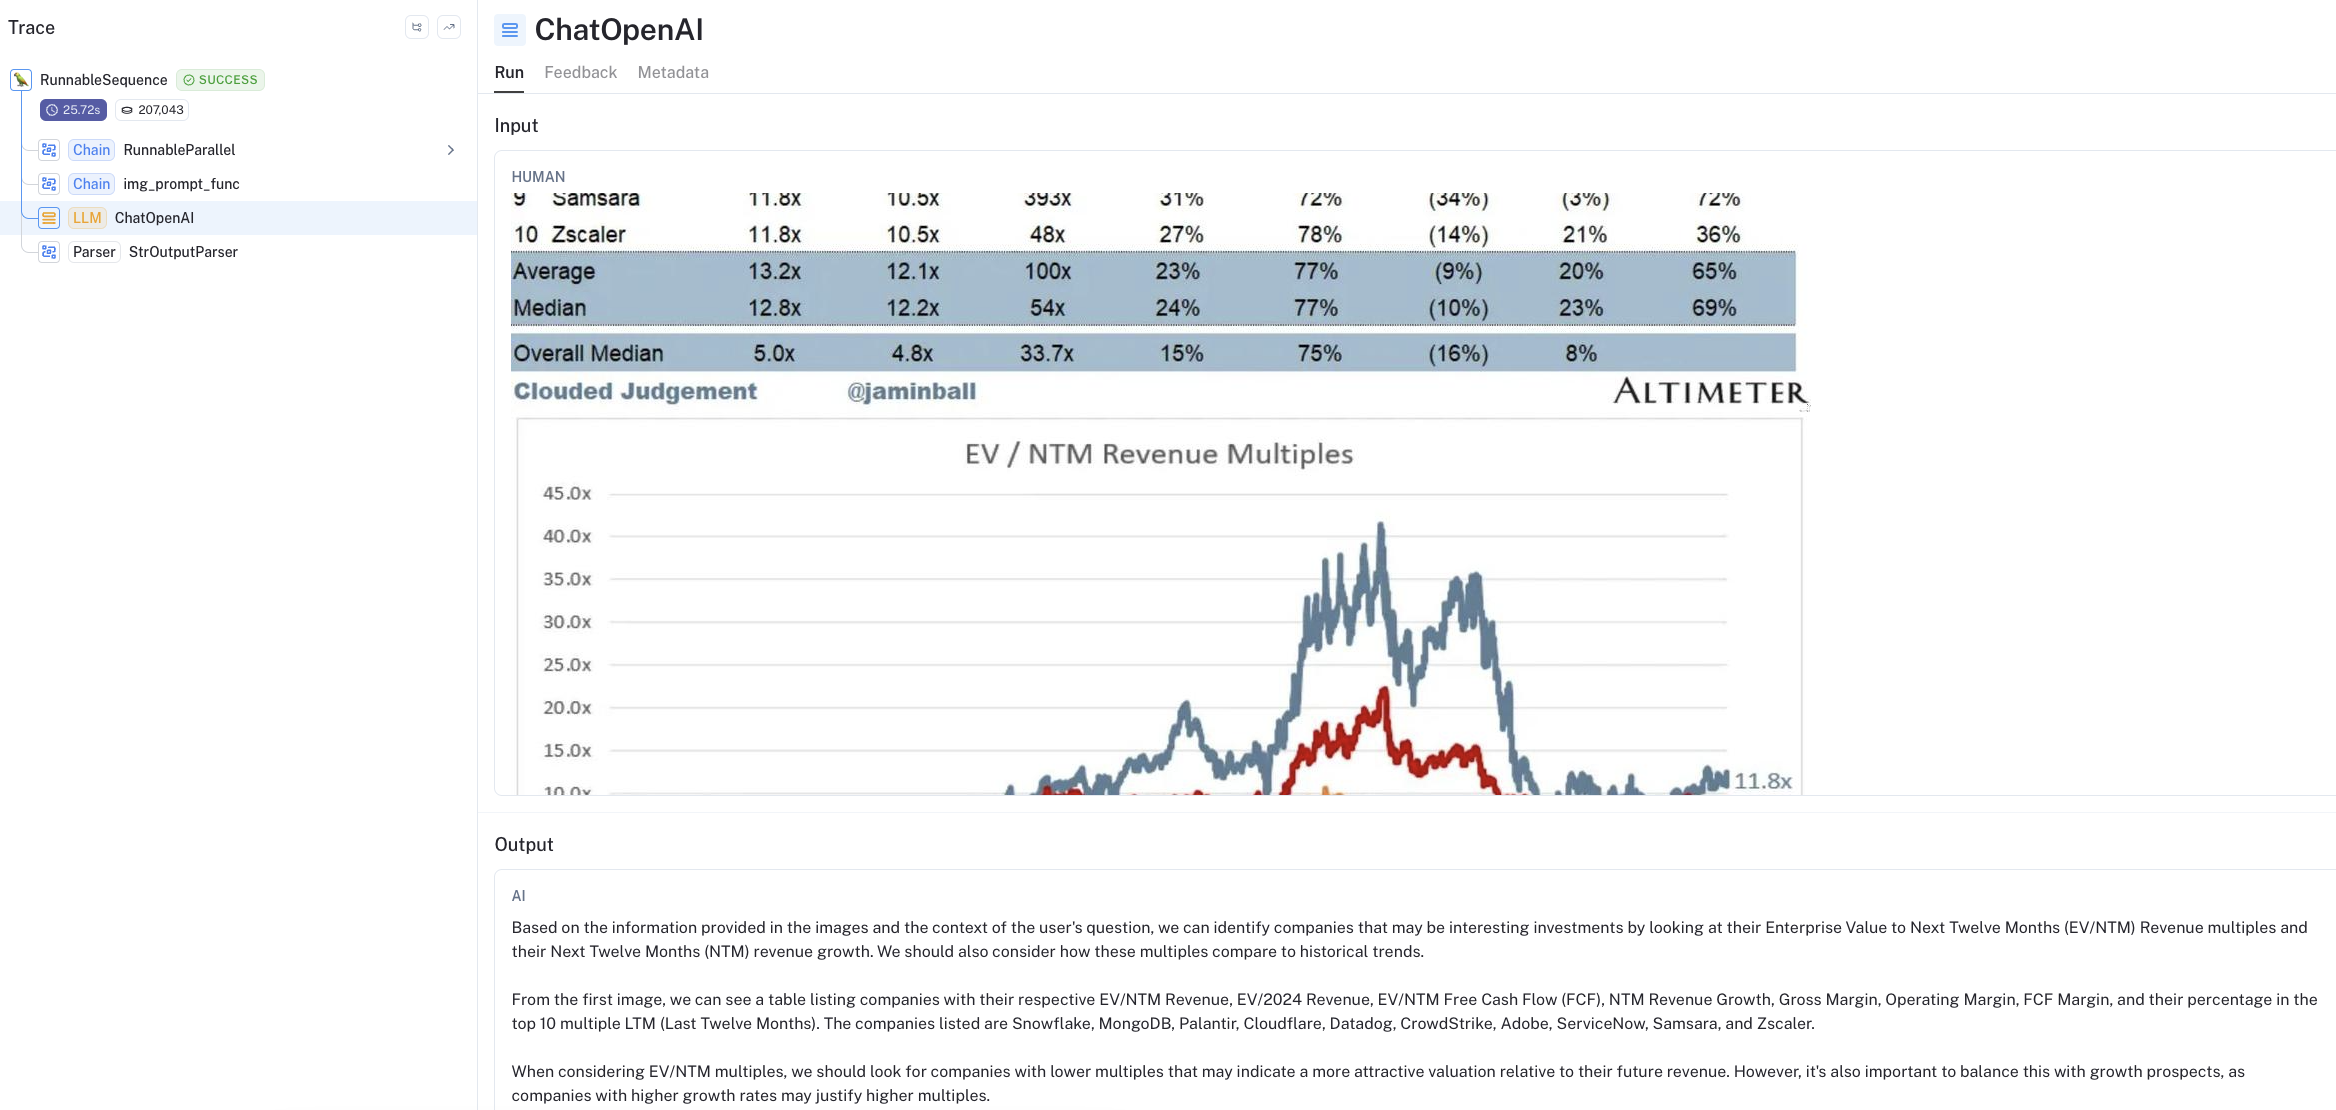

### Considerations

**Retrieval**
 
* Retrieval is performed based upon similarity to image summaries as well as text chunks.
* This requires some careful consideration because image retrieval can fail if there are competing text chunks.
* To mitigate this, I produce larger (4k token) text chunks and summarize them for retrieval.

**Image Size**

* The quality of answer synthesis appears to be sensitive to image size, [as expected](https://platform.openai.com/docs/guides/vision).
* I'll do evals soon to test this more carefully.